# Deep Learning: Downscale climate models

> * 🔬 Data Science
* 🤖 Machine Learning
* 🥠 Predictive Modeling
* 📈 Graphing and Visualization
* 🖥️ Requires ArcPy
* 👟 Ready To Run!

In this notebook, an essential component for making climate projections is addressed with spatial and non-spatial machine learning methods, namely climate downscaling. Downscaling is calibrating a global climate model with spatially-limited local temperature measurements.

For climate models, calibration can be done in various ways. One way of performing calibration is the so-called statistical downscaling that forms a statistical relationship between global climate models and temperature observations. For the inherently spatial problem of downscaling, we evaluate regression methods based on their method of handling spatial information.

1. Non-spatial (generic) machine learning
2. Spatial machine learning
3. Non-spatial machine learning with geoenriched predictors
  
## What is Statistical Climate Downscaling
### Overview
Scientists use Global Climate Models (GCMs) to model mesoscale to large scale (100s of kilometers) atmospheric dynamics of our planet. GCMs solve analytical equations, such as Navier-Stokes equations, to model global air flow and energy transfer in the atmosphere. In addition to global dynamics, weather is impacted by local effects such as distance to a water body, proximity to mountains, etc. These local effects are not modeled in GCMs. Thus, GCMs need to be calibrated with measurements collected at a finer scale. Fine-scale measurements of weather such as local temperature comes from weather stations that collect data continuously. In this analysis, we will be using weather measurements from a subset of weather stations in U.S. and CGCM1 climate model. Statistical downscaling is summarized below:

<img src=" 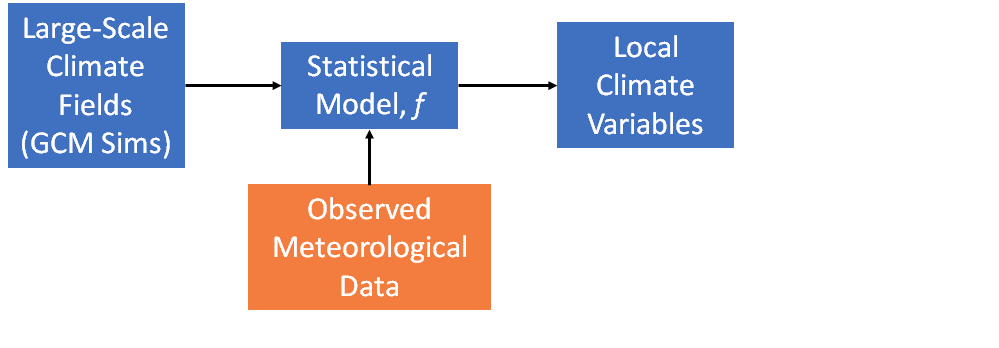">

### Predicting Climate Over Contiguous U.S.
Predicting future temperature using a GCM requires forming a statistically-valid relationship between coarse-scale climate model and fine-scale weather measurements using observed data. We will use 19 variables from CGCM1:

- Mean sea level pressure
- Airflow strength (simulated at 3 pressure levels)
- Surface zonal velocity (simulated at 3 pressure levels)
- Meridional velocity (simulated at 3 pressure levels)
- Surface vorticity (simulated at 3 pressure levels)
- Geopotential height (simulated 2 pressure levels)
- Zonal velocity (simulated at 2 pressure levels)
- Near surface relative humidity
- Near surface specific humidity

We will establish a relationship between simulated climate variables and measured average temperature to calibrate GCM. This process is known as downscaling and it can be done a number of ways (Wilby and Wigley, 1997). In this blog we will explore statistical downscaling. For the sake of demonstration, we will downscale GCM variables for a time snapshot: March 12, 2012 in the contiguous United States. 
Downscaling methods we will explore are summarized below.

<img src=" 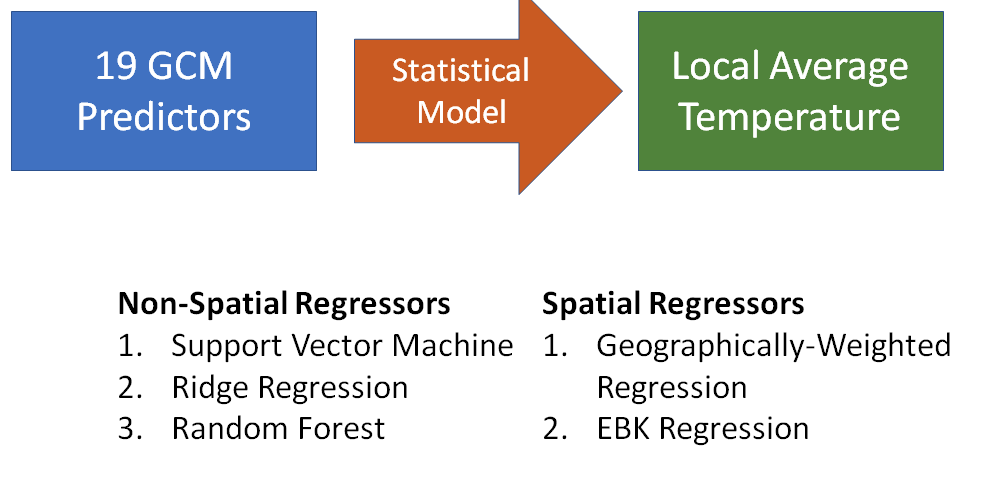">

## Approach
#### (1) Introduce Climate Downscaling
#### (2) Explain Regression Problem
#### (3) Methods we used: SVM/Ridge Regression method/GWR/RF

Let's get started.  First, we will import libraries that contain spatial and non-spatial regression models used throughout the study. In this notebook, we will use ArcPy and ArcGIS API for Python to perform spatial machine learning functions and data management, and scikit-learn will be used for non-spatial machine learning methods.

In [1]:
import os
import shutil
import zipfile

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.svm import SVR
from IPython.display import display
from IPython.display import IFrame

from arcgis.gis import GIS
import arcpy

In [2]:
IFrame(src='https://arcgis.com/apps/Minimalist/index.html'\
           '?appid=295c7fed9bbb413f8d8394b0effe1f71',
       width="100%", height="800px") 

Even though it is a must, we recommend making sure ArcPy is properly imported by running the GetInstallInfo function and querying the version of the ArcPy installed on ArcGIS Notebook Server.

In [3]:
arcpy.GetInstallInfo()['Version']

'10.7.0'

Connect to GIS. GIS enables interactive widgets to be embedded in analytical work and internally uses the ArcGIS API for JavaScript.

In [4]:
agol_gis = GIS(set_active=False)

#### Automatically authenticate to your WebGIS using your credentials

In [5]:
gis = GIS("home")

## 0. Environment setting 

### 0.1 Unzip uploaded GDB 

In [6]:
from shutil import unpack_archive

Let's copy the sample geodatabase used from this sample from `/arcgis/samplesdata/` to `/arcgis/home`

In [7]:
arcgis_dir = os.path.abspath(os.path.join(os.sep, 'arcgis', ''))
home_dir = os.path.join(arcgis_dir, 'home', '')

def copy_sample_gdb_to_home(gdb_zip_name):
    """Given the full filename (with extensions) of a gdb zip file in 
    /arcgis/samplesdata/, will copy and unzip that gdb to /arcgis/home/
    Will return the full path to the unzipped gdb in home"""

    # Get the full paths of all the source and destination files to copy
    gdb_dir_name = gdb_zip_name.split(".zip")[0]
    gdb_zip_path_src = os.path.join(arcgis_dir, 'samplesdata', 
                                    gdb_zip_name)
    gdb_dir_path_src = os.path.join(arcgis_dir, 'samplesdata', 
                                    gdb_dir_name)
    gdb_zip_path_dst = os.path.join(home_dir, gdb_zip_name)
    gdb_dir_path_dst = os.path.join(home_dir, gdb_dir_name)

    # If the gdb has been copied/unzipped to home dir before, delete it
    if os.path.exists(gdb_zip_path_dst):
        os.remove(gdb_zip_path_dst)
    if os.path.exists(gdb_dir_path_dst):
        shutil.rmtree(gdb_dir_path_dst)

    # Copy the zip file to home, unzip it
    shutil.copy(gdb_zip_path_src, gdb_zip_path_dst)
    zip_ref = zipfile.ZipFile(gdb_zip_path_dst, 'r')
    zip_ref.extractall(home_dir)
    zip_ref.close()
    
    # Return the output full path to /arcgis/home/unzipped_gdb/
    return os.path.join(gdb_dir_path_dst, '') # Adds trailing slash

gdb_path = copy_sample_gdb_to_home('climate_input.gdb.zip')
print(f"GDB succesfully copied to {gdb_path}")

GDB succesfully copied to /arcgis/home/climate_input.gdb/


### 0.2 Set up working environment

In [8]:
arcpy.env.workspace = gdb_path
outputSpace = home_dir
climate_output_gdb_path = os.path.join(home_dir, "climate_output.gdb")
if os.path.exists(climate_output_gdb_path):
    shutil.rmtree(climate_output_gdb_path)
arcpy.CreateFileGDB_management(outputSpace, "climate_output.gdb")
outGDB = os.path.join(outputSpace, "climate_output.gdb")

arcpy.env.overwriteOutput = True ## overwrite the output results

### 0.3 List the feature class in my working environment

In [9]:
datasets = arcpy.ListDatasets(feature_type='feature')
datasets = [''] + datasets if datasets is not None else []

## 1. Data Wrangling 
### 1.1 Filling Missing Station Values
#### There are a lot of them and we don't have much data to start with, so let's do FIMV.
#### There are some average surface temperature values are missing, and we need to fill the missing values.

In [10]:
station_fc = "station"

In [11]:
station_sdf = pd.DataFrame.spatial.from_featureclass(station_fc)

In [12]:
# show the temperature info from my station data
station_sdf[["T_MONTHLY_MAX", "T_MONTHLY_MIN", "T_MONTHLY_MEAN",
             "T_MONTHLY_AVG"]].head()

,T_MONTHLY_MAX,T_MONTHLY_MIN,T_MONTHLY_MEAN,T_MONTHLY_AVG
0,-9999.0,11.4,17.8,-9999.0
1,-9999.0,-9999.0,-9999.0,16.7
2,22.6,9.3,16.0,-9999.0
3,-9999.0,-9999.0,18.8,18.8
4,21.6,9.5,15.6,15.8


In [13]:
# As you can see, there are many -9999.0 in SUR_TEMP_MONTHLY_AVG. 
# -9999 represents missing values, and we need to use fill mising value 
# tool to fill those fields
# You can use the number of spatial neighbors for interpolating the 
# missing values; here we'll use five numbers of neighbors

station_fmv = os.path.join(outGDB, "station_filled_missing_value")

arcpy.stpm.FillMissingValues(station_fc, station_fmv,
    "T_MONTHLY_MAX;T_MONTHLY_MIN;T_MONTHLY_MEAN;T_MONTHLY_AVG",
    "AVERAGE", "K_NEAREST_NEIGHBORS", None, None, "TIME", 6, "WBANNO",
    None, None, None, None, -9999, None)

<Result '/arcgis/home/climate_output.gdb/station_filled_missing_value'>

In [14]:
station_fmv_sdf = pd.DataFrame.spatial.from_featureclass(station_fmv)

station_fmv_sdf[["T_MONTHLY_MAX", "T_MONTHLY_MIN",
                 "T_MONTHLY_MEAN", "T_MONTHLY_AVG"]].head()

,T_MONTHLY_MAX,T_MONTHLY_MIN,T_MONTHLY_MEAN,T_MONTHLY_AVG
0,24.54,11.40,17.80,18.04
1,23.06,9.82,16.48,16.70
2,22.60,9.30,16.00,16.48
3,24.80,12.04,18.80,18.80
4,21.60,9.50,15.60,15.80


### 1.2 Plot Local Station Data

In [15]:
# create a function which is able to plot the spatially enabled data frame
def visualizeFeatureClassBySEDF(myMap, fc, renderer_type,
                                method, class_count, col,
                                colors, alpha, line_width):
    sdf = pd.DataFrame.spatial.from_featureclass(fc)
    # change the spatial reference of the SEDF same as the map
    sdf.spatial.project(spatial_reference = {'wkid': 3857}) 
    sdf.spatial.plot(map_widget= myMap,renderer_type=renderer_type,
                     method=method, class_count=class_count,
                     col=col,colors=colors,alpha=alpha,
                     line_width=line_width)

In [16]:
sdf_map = agol_gis.map('United States',zoomlevel=4)
sdf_map

MapView(layout=Layout(height='400px', width='100%'), zoom=4.0)

In [46]:
visualizeFeatureClassBySEDF(sdf_map, station_fmv, renderer_type='c',
                            method='esriClassifyNaturalBreaks',
                            class_count=7,col="T_MONTHLY_AVG",
                            colors='Reds' ,alpha=0.5, line_width=0.5)

### 1.3 Resolve Scale and Discretization Differences
Global climate modeling is simulated at locations around the world. One of the global climate variables is visualized.

In [17]:
# First, let's plot the GCM data

def visualizeFeatureClassBySEDF_unique(myMap, fc, symbol_type,
                                       cmap,line_width,marker_size, 
                                       alpha):
    sdf = pd.DataFrame.spatial.from_featureclass(fc)
    # change the spatial reference of the SEDF same as the map
    sdf.spatial.project(spatial_reference = {'wkid': 3857})
    sdf.spatial.plot(map_widget= myMap,symbol_type=symbol_type,
                     cmap=cmap,line_width=line_width, 
                     marker_size=marker_size)

In [47]:
# We add the GCM data to the map above; as you can see, the locations of GCM data points do not coincide with the locations of stations
visualizeFeatureClassBySEDF_unique(sdf_map, "airFlow500_201203", 
                                   symbol_type='simple',
                                   cmap=[90,180,172,225],
                                   line_width= 0.5,
                                   marker_size=7,
                                   alpha="0.5")

In [18]:
# Since the locations of GCM data do not coincide with the
# locations of the real station, first, we need to interpolate GCM data
# and get the raster surfaces of GCM 

arcpy.env.extent = arcpy.Extent(-124.76308372794, 24.5230996116049, -66.9498936574818, 49.3843680121063)  # setting the extent as US polygon - this is important, as otherwise some parts of the US won't get the interpolated values
# run through a loop to create all GCM raster surfaces using EBK
gcm_lst = [("specHum2m_201203","shum"),("airT2m_201203","air"),
           ("geoHgt850_201203","hgt"),("geoHgt500_201203","hgt"),
           ("relHumSurf_201203","rhum"),("specHum850_201203","shum"),
           ("specHum500_201203","shum"),("vort850_201203","omega"),
           ("vort500_201203","omega"),("merid850_201203","vwnd"),
          ("merid500_201203","vwnd"),("zonal850_201203","uwnd"),
           ("zonal500_201203","uwnd"),("airFlow850_201203","wspd"),
           ("airFlow500_201203","wspd"),("airFlowSurf_201203","wspd"),
           ("vortSurf_201203","wspd"),("meridSurf_201203","vwnd"),
           ("seaLevP_201203","slp"),("zonalSurf_201203","uwnd")]

for gcm,value in gcm_lst:
    arcpy.env.workspace = home_dir + "/climate_input.gdb"
    file_name = str(gcm)+"_ebk_surface"
    output = os.path.join(outGDB, file_name)
    print(f'Calling arcpy.ga.EmpiricalBayesianKriging('\
          f'"{gcm}", "{value}", ...')
    arcpy.ga.EmpiricalBayesianKriging(gcm, value, None, output,
        9.94450736020055E-02, "NONE", 100, 1, 100,
        "NBRTYPE=StandardCircular RADIUS=15 ANGLE=0 "\
        "NBR_MAX=15 NBR_MIN=10 SECTOR_TYPE=ONE_SECTOR",
        "PREDICTION", 0.5, "EXCEED", None, "POWER")

Calling arcpy.ga.EmpiricalBayesianKriging("specHum2m_201203", "shum", ...
Calling arcpy.ga.EmpiricalBayesianKriging("airT2m_201203", "air", ...
Calling arcpy.ga.EmpiricalBayesianKriging("geoHgt850_201203", "hgt", ...
Calling arcpy.ga.EmpiricalBayesianKriging("geoHgt500_201203", "hgt", ...
Calling arcpy.ga.EmpiricalBayesianKriging("relHumSurf_201203", "rhum", ...
Calling arcpy.ga.EmpiricalBayesianKriging("specHum850_201203", "shum", ...
Calling arcpy.ga.EmpiricalBayesianKriging("specHum500_201203", "shum", ...
Calling arcpy.ga.EmpiricalBayesianKriging("vort850_201203", "omega", ...
Calling arcpy.ga.EmpiricalBayesianKriging("vort500_201203", "omega", ...
Calling arcpy.ga.EmpiricalBayesianKriging("merid850_201203", "vwnd", ...
Calling arcpy.ga.EmpiricalBayesianKriging("merid500_201203", "vwnd", ...
Calling arcpy.ga.EmpiricalBayesianKriging("zonal850_201203", "uwnd", ...
Calling arcpy.ga.EmpiricalBayesianKriging("zonal500_201203", "uwnd", ...
Calling arcpy.ga.EmpiricalBayesianKriging("airF

In [19]:
# We can list all raster files in the output gdb to make sure our 
# EBK outputs are in there

# Reset the current workspace
arcpy.env.workspace = home_dir + "climate_output.gdb" 

In [20]:
# extract the values from the raster surface to the points of stations. 
# The "extract multi value to points" method can help us to do that
arcpy.env.workspace = home_dir + "/climate_input.gdb"

# since we don't want to change the original input station data, 
# we make a copy to climate_output.gdb
arcpy.CopyFeatures_management(station_fmv, 
    home_dir + "/climate_output.gdb/station_GCM")  

arcpy.env.workspace = home_dir + "/climate_output.gdb"
arcpy.sa.ExtractMultiValuesToPoints("station_GCM", 
    [["specHum2m_201203_ebk_surface", "specHum2m"], 
     ["airT2m_201203_ebk_surface", "airT2m"], 
     ["geoHgt850_201203_ebk_surface", "geoHgt850"],
     ["geoHgt500_201203_ebk_surface","geoHgt500"],
     ["relHumSurf_201203_ebk_surface","relHumSurf"],
     ["specHum500_201203_ebk_surface","specHum500"],
     ["specHum850_201203_ebk_surface","specHum850"],
     ["vort850_201203_ebk_surface","vort850"],
     ["vort500_201203_ebk_surface","vort500"],
     ["merid850_201203_ebk_surface","merid850"],
     ["merid500_201203_ebk_surface","merid500"],  
     ["zonal850_201203_ebk_surface","zonal850"],
     ["zonal500_201203_ebk_surface","zonal500"],
     ["airFlow850_201203_ebk_surface","airFlow850"],
     ["airFlow500_201203_ebk_surface","airFlow500"],
     ["airFlowSurf_201203_ebk_surface","airFlowSurf"],
     ["vortSurf_201203_ebk_surface","vortSurf"],
     ["meridSurf_201203_ebk_surface","meridSurf"],
     ["seaLevP_201203_ebk_surface","seaLevP"],
     ["zonalSurf_201203_ebk_surface","zonalSurf"]],
    "NONE")

<geoprocessing server result object at 0x7f47adb77f08>

In [21]:
# now the station data gets the values from 20 GCM raster surfaces, 
# we can check them by listing the files in our data
arcpy.env.workspace = home_dir + "/climate_output.gdb"
fields = arcpy.ListFields("station_GCM")
station_predictors = ["airT2m","geoHgt850","geoHgt850",
                      "geoHgt500","relHumSurf","specHum500",
                      "specHum850","vort850","vort500","merid850",
                      "vort500","merid850", "merid500","zonal850",
                      "zonal500","airFlow850","airFlow500","airFlowSurf",
                      "vortSurf","meridSurf","seaLevP","zonalSurf"]
station_predictand = ["T_MONTHLY_AVG"]

In [22]:
# here are the variables we will use later
station_GCM = os.path.join(outGDB, "station_GCM")
station_GCM_sdf = pd.DataFrame.spatial.from_featureclass(station_GCM)
station_GCM_sdf[station_predictors + station_predictand].head()

,airT2m,geoHgt850,geoHgt850,geoHgt500,relHumSurf,specHum500,specHum850,vort850,vort500,merid850,...,zonal850,zonal500,airFlow850,airFlow500,airFlowSurf,vortSurf,meridSurf,seaLevP,zonalSurf,T_MONTHLY_AVG
0,289.849213,164.443024,164.443024,164.443024,84.124435,10.733868,10.733868,-0.000187,-0.000187,1.560632,...,-0.228055,-0.228055,4.300753,4.300753,3.480743,3.480743,1.641173,1019.500061,0.168134,18.04
1,288.776917,159.583237,159.583237,159.583237,81.953171,10.155221,10.155221,0.009756,0.009756,1.874495,...,0.081150,0.081150,4.569221,4.569221,4.804224,4.804224,2.306259,1018.818359,0.031886,16.70
2,288.779755,161.611938,161.611938,161.611938,82.471779,10.262570,10.262570,0.007005,0.007005,1.700716,...,0.011286,0.011286,4.380100,4.380100,4.402224,4.402224,2.013057,1019.115356,0.132225,16.48
3,292.476349,165.336807,165.336807,165.336807,83.303917,11.522954,11.522954,-0.002438,-0.002438,2.187343,...,-0.947112,-0.947112,4.986618,4.986618,3.740792,3.740792,1.571567,1019.343567,-0.971350,18.80
4,288.211273,163.101761,163.101761,163.101761,82.624016,10.282774,10.282774,0.005627,0.005627,1.584904,...,0.027554,0.027554,4.157563,4.157563,4.306343,4.306343,1.747068,1019.363281,0.216421,15.80


### 1.4 Create Prediction Location

Now, we have almost prepared all input data for our analysis, but we also need to prepare prediction locations. "US_Prediction_Grid" is the predicted grid that we created in advance, and we need to use the "Extract multi value to points" method again to extract values from raster surface data.

In [23]:
arcpy.env.workspace = home_dir + "/climate_input.gdb"
station = "US_Prediction_Grid"

# since we don't want to change the original input US_Prediction_Grid 
# data, we make a copy to climate_output.gdb
arcpy.CopyFeatures_management(station,
    home_dir + "/climate_output.gdb/US_Prediction_Grid_GCM")  

arcpy.env.workspace = home_dir + "/climate_output.gdb"
arcpy.sa.ExtractMultiValuesToPoints("US_Prediction_Grid_GCM",
    [["specHum2m_201203_ebk_surface", "specHum2m"], 
     ["airT2m_201203_ebk_surface", "airT2m"], 
     ["geoHgt850_201203_ebk_surface", "geoHgt850"],
     ["geoHgt500_201203_ebk_surface","geoHgt500"],
     ["relHumSurf_201203_ebk_surface","relHumSurf"],
     ["specHum500_201203_ebk_surface","specHum500"],
     ["specHum850_201203_ebk_surface","specHum850"],
     ["vort850_201203_ebk_surface","vort850"],
     ["vort500_201203_ebk_surface","vort500"],
     ["merid850_201203_ebk_surface","merid850"],
     ["merid500_201203_ebk_surface","merid500"],  
     ["zonal850_201203_ebk_surface","zonal850"],
     ["zonal500_201203_ebk_surface","zonal500"],
     ["airFlow850_201203_ebk_surface","airFlow850"],
     ["airFlow500_201203_ebk_surface","airFlow500"],
     ["airFlowSurf_201203_ebk_surface","airFlowSurf"],
     ["vortSurf_201203_ebk_surface","vortSurf"],
     ["meridSurf_201203_ebk_surface","meridSurf"],
     ["seaLevP_201203_ebk_surface","seaLevP"],
     ["zonalSurf_201203_ebk_surface","zonalSurf"]], 
    "NONE")

<geoprocessing server result object at 0x7f47ace43aa8>

In [24]:
# now the US_Prediction_Grid data gets the values from 20 GCM raster 
# surfaces. We can check them by listing the files in our data
arcpy.env.workspace = home_dir + "/climate_output.gdb" 
fields = arcpy.ListFields("US_Prediction_Grid_GCM")

In [25]:
# Check the extracting data
US_Prediction_Grid_GCM = os.path.join(outGDB, "US_Prediction_Grid_GCM")      
output_GCM_sdf =  pd.DataFrame.spatial.from_featureclass(
    US_Prediction_Grid_GCM)
output_GCM_sdf.head()

,OBJECTID,FID_USdown,FID_US_pol,airFlow850,airFlowSur,airT2m_201,geoHgt500_,geoHgt850_,merid500_2,merid850_2,...,zonal850,zonal500,airFlow850_1,airFlow500_1,airFlowSurf,vortSurf,meridSurf,seaLevP,zonalSurf,SHAPE
0,1,65667,748,3.78559,4.60107,286.886993,117.762001,117.762001,0.894856,0.894856,...,1.982475,1.982475,4.088900,4.088900,4.638579,4.638579,0.974592,1013.396057,1.815351,"{""x"": -105.51129143475185, ""y"": 31.06161320108..."
1,2,65668,748,3.81009,4.62228,287.040985,117.556000,117.556000,0.927791,0.927791,...,1.972188,1.972188,4.107887,4.107887,4.665758,4.665758,1.019339,1013.370911,1.796262,"{""x"": -105.39566505429877, ""y"": 31.06161320108..."
2,3,65669,748,3.86146,4.66634,287.350006,117.151001,117.151001,0.997158,0.997158,...,1.960618,1.960618,4.127301,4.127301,4.692918,4.692918,1.065441,1013.346924,1.774962,"{""x"": -105.2800386738457, ""y"": 31.061613201088..."
3,4,65670,748,3.88835,4.68925,287.489014,116.954002,116.954002,1.033590,1.033590,...,1.931506,1.931506,4.168343,4.168343,4.756423,4.756423,1.177940,1013.292419,1.715283,"{""x"": -105.16441229429194, ""y"": 31.06161320108..."
4,5,65671,748,3.91607,4.71277,287.639008,116.760002,116.760002,1.071180,1.071180,...,1.916167,1.916167,4.189304,4.189304,4.783813,4.783813,1.228021,1013.271912,1.687406,"{""x"": -105.0487859138388, ""y"": 31.061613201088..."


## 2. Explore the Relationship between variables 

In [26]:
station_GCM = os.path.join(outGDB, "station_GCM")
station_GCM_sdf = pd.DataFrame.spatial.from_featureclass(station_GCM)

In [27]:
gcm_variables = station_GCM_sdf[station_predictors]

In [28]:
gcm_variables.head()

,airT2m,geoHgt850,geoHgt850,geoHgt500,relHumSurf,specHum500,specHum850,vort850,vort500,merid850,...,merid500,zonal850,zonal500,airFlow850,airFlow500,airFlowSurf,vortSurf,meridSurf,seaLevP,zonalSurf
0,289.849213,164.443024,164.443024,164.443024,84.124435,10.733868,10.733868,-0.000187,-0.000187,1.560632,...,1.560632,-0.228055,-0.228055,4.300753,4.300753,3.480743,3.480743,1.641173,1019.500061,0.168134
1,288.776917,159.583237,159.583237,159.583237,81.953171,10.155221,10.155221,0.009756,0.009756,1.874495,...,1.874495,0.081150,0.081150,4.569221,4.569221,4.804224,4.804224,2.306259,1018.818359,0.031886
2,288.779755,161.611938,161.611938,161.611938,82.471779,10.262570,10.262570,0.007005,0.007005,1.700716,...,1.700716,0.011286,0.011286,4.380100,4.380100,4.402224,4.402224,2.013057,1019.115356,0.132225
3,292.476349,165.336807,165.336807,165.336807,83.303917,11.522954,11.522954,-0.002438,-0.002438,2.187343,...,2.187343,-0.947112,-0.947112,4.986618,4.986618,3.740792,3.740792,1.571567,1019.343567,-0.971350
4,288.211273,163.101761,163.101761,163.101761,82.624016,10.282774,10.282774,0.005627,0.005627,1.584904,...,1.584904,0.027554,0.027554,4.157563,4.157563,4.306343,4.306343,1.747068,1019.363281,0.216421


In [29]:
# Let's create a correlation martix to check the relationship
cor_table=gcm_variables.corr()
cor_table

,airT2m,geoHgt850,geoHgt850,geoHgt500,relHumSurf,specHum500,specHum850,vort850,vort500,merid850,...,merid500,zonal850,zonal500,airFlow850,airFlow500,airFlowSurf,vortSurf,meridSurf,seaLevP,zonalSurf
airT2m,1.000000,0.523639,0.523639,0.523639,0.024602,0.453666,0.453666,-0.158646,-0.158646,0.115328,...,0.115328,-0.511303,-0.511303,0.347236,0.347236,0.015608,0.015608,-0.023069,0.447385,-0.424286
geoHgt850,0.523639,1.000000,1.000000,1.000000,0.289858,0.493986,0.493986,-0.291146,-0.291146,-0.217218,...,-0.217218,-0.486174,-0.486174,-0.025860,-0.025860,-0.486201,-0.486201,-0.264305,0.988291,-0.476785
geoHgt850,0.523639,1.000000,1.000000,1.000000,0.289858,0.493986,0.493986,-0.291146,-0.291146,-0.217218,...,-0.217218,-0.486174,-0.486174,-0.025860,-0.025860,-0.486201,-0.486201,-0.264305,0.988291,-0.476785
geoHgt500,0.523639,1.000000,1.000000,1.000000,0.289858,0.493986,0.493986,-0.291146,-0.291146,-0.217218,...,-0.217218,-0.486174,-0.486174,-0.025860,-0.025860,-0.486201,-0.486201,-0.264305,0.988291,-0.476785
relHumSurf,0.024602,0.289858,0.289858,0.289858,1.000000,0.656611,0.656611,-0.077643,-0.077643,0.327936,...,0.327936,-0.486520,-0.486520,0.378329,0.378329,0.079683,0.079683,0.355062,0.345988,-0.514809
specHum500,0.453666,0.493986,0.493986,0.493986,0.656611,1.000000,1.000000,-0.002722,-0.002722,0.377871,...,0.377871,-0.661489,-0.661489,0.237164,0.237164,-0.040895,-0.040895,0.333365,0.511869,-0.591803
specHum850,0.453666,0.493986,0.493986,0.493986,0.656611,1.000000,1.000000,-0.002722,-0.002722,0.377871,...,0.377871,-0.661489,-0.661489,0.237164,0.237164,-0.040895,-0.040895,0.333365,0.511869,-0.591803
vort850,-0.158646,-0.291146,-0.291146,-0.291146,-0.077643,-0.002722,-0.002722,1.000000,1.000000,-0.190525,...,-0.190525,0.437514,0.437514,0.091073,0.091073,0.193134,0.193134,-0.185647,-0.270364,0.541750
vort500,-0.158646,-0.291146,-0.291146,-0.291146,-0.077643,-0.002722,-0.002722,1.000000,1.000000,-0.190525,...,-0.190525,0.437514,0.437514,0.091073,0.091073,0.193134,0.193134,-0.185647,-0.270364,0.541750
merid850,0.115328,-0.217218,-0.217218,-0.217218,0.327936,0.377871,0.377871,-0.190525,-0.190525,1.000000,...,1.000000,-0.377805,-0.377805,0.510818,0.510818,0.615799,0.615799,0.929763,-0.231771,-0.304147


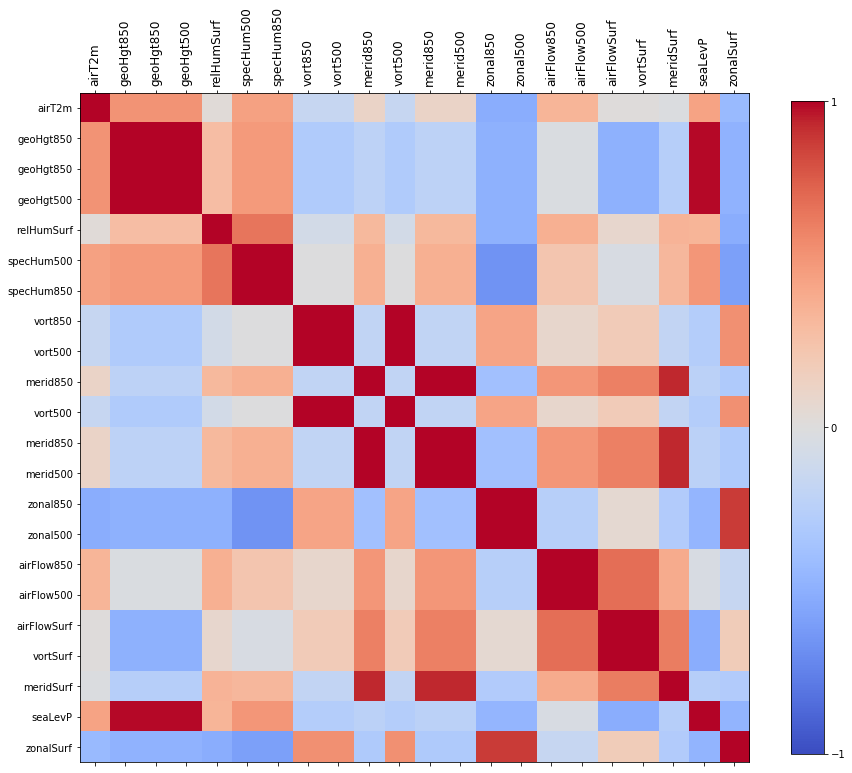

In [30]:
# colors make the correlation matrix more readable
size = 15
fig, ax = plt.subplots(figsize=(size, size))
cax = ax.matshow(cor_table,cmap=cm.get_cmap('coolwarm'), vmin=-1,vmax=1)
fig.colorbar(cax, ticks=[1,0,-1], shrink=0.8)
plt.xticks(range(len(gcm_variables.columns)), gcm_variables.columns, 
           rotation='vertical', fontsize=12)
plt.yticks(range(len(gcm_variables.columns)), gcm_variables.columns)

plt.show()

## 3. Analysis:  Average Temperature Prediction

### 3.1 Support Vector Machine (SVM) VS. Ridge Regression
#### 3.1.1. Ridge Regression for Climate Downscaling

In [31]:
ridge = RidgeCV(alphas=np.logspace(-10, 10, 10), 
                fit_intercept = True, normalize = True, 
                store_cv_values = True)
ridge.fit(station_GCM_sdf[station_predictors], 
          station_GCM_sdf[station_predictand])

RidgeCV(alphas=array([1.00000e-10, 1.66810e-08, 2.78256e-06, 4.64159e-04, 7.74264e-02, 1.29155e+01, 2.15443e+03, 3.59381e+05,
       5.99484e+07, 1.00000e+10]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=True,
    scoring=None, store_cv_values=True)

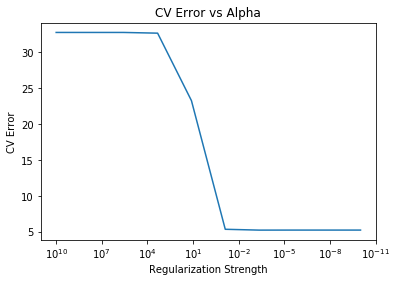

In [32]:
ax = plt.gca()
ax.plot(ridge.alphas.ravel(), 
        np.mean(ridge.cv_values_, 
        axis = 0).ravel())
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('Regularization Strength')
plt.ylabel('CV Error')
plt.title('CV Error vs Alpha')
plt.axis('tight')
plt.show()

In [33]:
print('Optimal Regularization Parameter = {0}'.format(ridge.alpha_))

Optimal Regularization Parameter = 0.0004641588833612782


#### 3.1.2 Support Vector Machine for Climate Downscaling

In [34]:
svr_rbf = SVR(kernel= 'rbf', C = 1.0, gamma='auto').fit(
    station_GCM_sdf[station_predictors],
    station_GCM_sdf[station_predictand].values.ravel())

In [35]:
svr_rbf.predict(output_GCM_sdf[station_predictors])

array([10.178156, 10.247221, 10.389448, 10.494384, ...,  9.024728,  9.024996,  9.054723,  9.058166])

In [36]:
from IPython.display import IFrame
IFrame(src='https://eath.maps.arcgis.com/apps/StorytellingSwipe/'\
           'index.html?appid=ca2c84c6611140f6883f9843c06d1d56#',
       width="100%", height="800px") 

### 3.2 EBK Regression Prediction  VS.  Geographically Weighted Regression (GWR)

In [37]:
# Let's use EBK regression to predict average temperature
arcpy.env.workspace = home_dir + "/climate_output.gdb"
input_feature = station_fmv
out_ga_layer = "EBK_pred_ga"
out_raster = "EBK_pred_raster"

arcpy.ga.EBKRegressionPrediction(station_fmv, "T_MONTHLY_AVG",
    "vort850_201203_ebk_surface;specHum850_201203_ebk_surface;"\
    "zonalSurf_201203_ebk_surface", out_ga_layer, out_raster, 
    None, None, 95, None, "NONE", "EXPONENTIAL", 100, 1, 100, 
    "NBRTYPE=StandardCircular RADIUS=15 ANGLE=0 NBR_MAX=15 "\
    "NBR_MIN=10 SECTOR_TYPE=ONE_SECTOR")

<Result 'EBK_pred_ga'>

In [38]:
# Now, we use GWR to predict average temperature and compare the 
# result with EBK

arcpy.env.workspace = home_dir + "/climate_output.gdb"
input_feature = station_GCM
out_feature_class = os.path.join(outGDB, "GWR_out_feature_class")
kernal = "ADAPTIVE"
number_of_neighbor = 30
prediction_location = "US_Prediction_Grid_GCM"
prediction_output = "GWR_pred"

arcpy.stats.GeographicallyWeightedRegression(input_feature, 
    "T_MONTHLY_AVG", "specHum850;vort850;zonalSurf", 
     out_feature_class, kernal,"BANDWIDTH_PARAMETER", 
     None, number_of_neighbor, None, None, 9.22719999999999E-02, 
     prediction_location,"specHum850;vort850;zonalSurf",prediction_output)

<Result '/arcgis/home/climate_output.gdb/GWR_out_feature_class'>

In [39]:
from IPython.display import IFrame
IFrame(src='https://eath.maps.arcgis.com/apps/StorytellingSwipe/'\
            'index.html?appid=fe637afce2a4436db5332d08704722e2#',
       width="100%", height="800px") 

In [40]:
# The predicted output using GWR tool is point type. To better visualize continouous value (temperature), we convert the points result into raster with point to raster method. 
arcpy.env.workspace = home_dir + "/climate_output.gdb" 
input_feature = "GWR_pred"
output_result = "GWR_pred_raster"
assignmentType = "MEAN"
priorityField = ""
cellSize = "2000"

arcpy.PointToRaster_conversion(input_feature, "PREDICTED", 
                               output_result, assignmentType, 
                               priorityField, cellSize)

<Result '/arcgis/home//climate_output.gdb/GWR_pred_raster'>


### 3.3 Forest-Based Classification and Regression VS. Forest-Based Classification and Regression with Distance Features 

In [41]:
# use Forest-Based Classification and Regression method to predict average temperature

arcpy.env.workspace = home_dir + "/climate_output.gdb"
input_feature = "station_GCM"
predict_location = "US_Prediction_Grid_GCM"
output_result = "RF_pred"


arcpy.stats.Forest("PREDICT_FEATURES", input_feature, "T_MONTHLY_AVG",
    None,"zonalSurf false;zonal850 false;zonal500 false;"\
         "vortSurf false;vort850 false;vort500 false;specHum850 "\
         "false;specHum500 false;specHum2m false;"\
         "seaLevP false;relHumSurf false;meridSurf false;"\
         "merid850 false;merid500 false;geoHgt850 false;"\
         "geoHgt500 false;airT2m false;airFlowSurf false;airFlow850 "\
         "false;airFlow500 false", 
    None, None, predict_location, output_result, None, 
         "specHum2m specHum2m;airT2m airT2m;geoHgt850 geoHgt850;"\
         "geoHgt500 geoHgt500;relHumSurf relHumSurf;specHum850 "\
         "specHum850;vort850 vort850;vort500 vort500;merid850 "\
         "merid850;merid500 merid500; zonal850 zonal850;zonal500 "\
         "zonal500; airFlow850 airFlow850;airFlow500 airFlow500 "\
         "airFlowSurf airFlowSurf; vortSurf vortSurf; meridSurf "\
         "meridSurf;seaLevP seaLevP;zonalSurf zonalSurf", 
    None, None, None, None, "TRUE", 100, None, None, 100, None, 10)

<Result '/arcgis/home//climate_output.gdb/RF_pred'>

In [42]:
# The predicted output using Forest-Based Classification and 
# Regression method is point type. To better visualize continouous 
# value (temperature), we convert the points result into raster with 
# point to raster method. 
arcpy.env.workspace = home_dir + "/climate_output.gdb"
input_feature = "RF_pred"
output_result = "RF_pred_raster"
assignmentType = "MEAN"
priorityField = ""
cellSize = "2000"

arcpy.PointToRaster_conversion(input_feature, "PREDICTED", 
                                output_result, assignmentType,
                               priorityField, cellSize)

<Result '/arcgis/home//climate_output.gdb/RF_pred_raster'>

Since the distance features to be applied for the Forest() method later would require a coordinate system defined, the cell below is to use the existing arcpy method "DefineProjection_management" to have the projection defined.

In [43]:
try:
    # set workspace environment
    arcpy.env.workspace = home_dir + "/climate_output.gdb"
    
    # get the coordinate system by describing a feature class
    dsc = arcpy.Describe("station_GCM")
    coord_sys = dsc.spatialReference
    
    # set local variables
    in_dataset = "Large_Water_Body"
    
    # set workspace environment
    arcpy.env.workspace = home_dir + "/climate_input.gdb"
    
    # run the tool
    arcpy.DefineProjection_management(in_dataset, coord_sys)
    
    # print messages when the tool runs successfully
    print(arcpy.GetMessages(0))
    
except arcpy.ExecuteError:
    print(arcpy.GetMessages(2))
    
except Exception as ex:
    print(ex.args[0])

Start Time: Wednesday, February 13, 2019 2:52:49 AM
Succeeded at Wednesday, February 13, 2019 2:52:50 AM (Elapsed Time: 1.75 seconds)


In [44]:
# The power of GIS is that we consider space, so next, we include 
# the distance of water body to our analysis
arcpy.env.workspace = home_dir + "/climate_output.gdb"
input_feature = "station_GCM"
output_result = "RF_pred_water_body"
distance_feature = home_dir + "/climate_input.gdb/Large_Water_Body"

arcpy.stats.Forest("PREDICT_FEATURES", input_feature, "T_MONTHLY_AVG", 
    None, "zonalSurf false;zonal850 false;zonal500 false;"\
          "vortSurf false;vort850 false;vort500 false;specHum850 "\
          "false;specHum500 false;specHum2m false;"\
          "seaLevP false;relHumSurf false;meridSurf false;merid850 "\
          "false;merid500 false;geoHgt850 false;"\
          "geoHgt500 false;airT2m false;airFlowSurf false;airFlow850 "\
          "false;airFlow500 false",
    distance_feature, None, "US_Prediction_Grid_GCM", output_result,
    None, "specHum2m specHum2m;airT2m airT2m;geoHgt850 "\
          "geoHgt850;geoHgt500 geoHgt500;relHumSurf "\
          "relHumSurf;specHum850 specHum850;"\
          "vort850 vort850;vort500 vort500;merid850 merid850;merid500 "\
          "merid500; zonal850 zonal850;zonal500 zonal500; airFlow850 "\
          "airFlow850;airFlow500 airFlow500 "\
          "airFlowSurf airFlowSurf; vortSurf vortSurf; meridSurf "\
          "meridSurf;seaLevP seaLevP;zonalSurf zonalSurf",
    None, None, None, None, "TRUE", 100, None, None, 100, None, 10)


<Result '/arcgis/home//climate_output.gdb/RF_pred_water_body'>

In [45]:
from IPython.display import IFrame
IFrame(src='https://eath.maps.arcgis.com/apps/StorytellingSwipe/'\
           'index.html?appid=409a3bf73fca49c1a8cc77c20900f30d#',
       width="100%", height="800px") 

### Conclusions
In this study, we explored different means of incorporating spatial information in climate model downscaling.